## Общее описание:
Есть данные о такси-компании (uber), которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения (и после – провести A/B тест и выяснить, стало ли лучше).

### Описание данных

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Создадим лейбл churn/not_churn
    - Построим графики
    - **Поинт:** только по графикам выводы делать – bad practice, хорошо подкреплять стат. тестами (и стат. тесты есть не только в A/B)
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)



## 1: загружаем
Еще раз список переменных:

- `city` – город
- `phone` – основное устройство, которое использует водитель 
- `signup_date` – дата регистрации аккаунта (`YYYYMMDD`)
- `last_trip_date` – дата последней поездки (`YYYYMMDD`)
- `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
- `avg_rating_by_driver` – средняя оценка поездок водителем 
- `avg_rating_of_driver` – средняя оценка поездок водителя
- `surge_pct` – процент поездок, совершенных с множителем > 1 
- `avg_surge` – средний множитель всплеска за все поездки этого водителя
- `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
- `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
- `weekday_pct` – процент поездок пользователя, совершенных в будние дни


In [39]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [3]:
df = pd.read_csv('/Users/anastasialutsuk/Desktop/карпов/churn.csv')

In [4]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
# Посмотрим на размер датасета
df.shape

(50000, 12)

In [42]:
# Проверим есть ли пустые данные
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
days_since_last_trip         0
churn                        0
dtype: int64

In [7]:
# Проверим данные на уникальность
df.nunique()

avg_dist                  2908
avg_rating_by_driver        27
avg_rating_of_driver        37
avg_surge                  115
city                         3
last_trip_date             182
phone                        2
signup_date                 31
surge_pct                  367
trips_in_first_30_days      59
luxury_car_user              2
weekday_pct                666
dtype: int64

In [43]:
# Посмотрим типы данных
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
days_since_last_trip               int64
churn                             object
dtype: object

In [44]:
# Изменяем тип для дат:

In [45]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
 12  days_since_last_trip    50000 non-null  int64 

In [47]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,days_since_last_trip
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,72.665220
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503,61.718985
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,13.000000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,54.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,137.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,181.000000


In [48]:
df.describe(include='object')

,city,phone,churn
count,50000,49604,50000
unique,3,2,2
top,Winterfell,iPhone,churn
freq,23336,34582,31196


In [49]:
df.describe(include='datetime')

<ipython-input-49-41adad5e0539>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

<ipython-input-49-41adad5e0539>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29 00:00:00,2014-01-18 00:00:00
freq,2036,2948
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-07-01 00:00:00,2014-01-31 00:00:00


Создаем лейбл churn – пользователь ушел, если не был активен последние 30 дней (но можно попробовать и другие значения в зависимости от вашей компании/данных)

In [50]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

In [51]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [52]:
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразуем в int:

In [53]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

In [54]:
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

In [55]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
df[['days_since_last_trip', 'churn']][:5]

,days_since_last_trip,churn
0,14,not_churn
1,57,churn
2,175,churn
3,2,not_churn
4,108,churn


In [59]:
df.churn.value_counts()

churn        31196
not_churn    18804
Name: churn, dtype: int64

Видим, что очень много пользователей не использовали сервис в последнем месяце. Нужно разобраться, какие факторы могут влиять на отток водителей

In [60]:
# % пользовательей которые ушли и остались
df.churn.value_counts(normalize=True).mul(100)
#df.churn.value_counts()/df.churn.count()*100

churn        62.392
not_churn    37.608
Name: churn, dtype: float64

<AxesSubplot:xlabel='churn', ylabel='Count'>

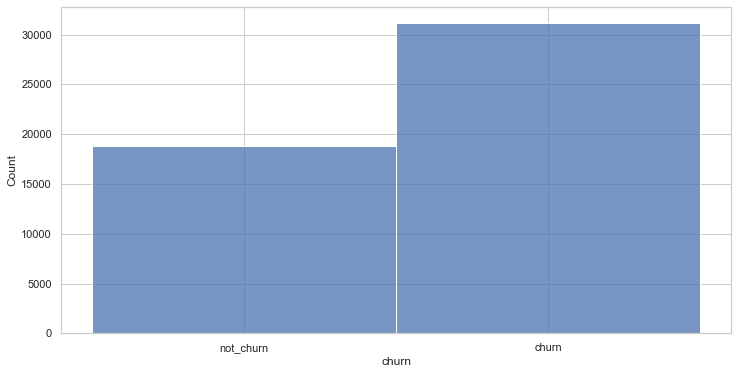

In [61]:
sns.histplot(df, x='churn')

Еще лучше – отразим на графике нормализованные значения (сравниваем не сырые числа):

In [22]:
fig = px.histogram(df, x='churn', histnorm='probability density') # probability density % стоотношение
fig.show()

### churn & phone

Предположим, что проблема может быть среди юзеров на конкретной платформе:

In [62]:
pd.crosstab(df.churn, df.phone)

phone,Android,iPhone
churn,,
churn,11876,19057
not_churn,3146,15525


In [63]:
fig = px.histogram(df[['churn', 'phone']].dropna(), x='churn', 
                   color='phone')
fig.show()

Делать вывод только по графику – не очень хорошо, поэтому проверим нашу гипотезу с помощью статистического теста.

Есть две категориальные переменные → нужен хи-квадрат

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [70]:
# ХИ квадрат проверяет что данные в группах распределены одинково
from scipy.stats import chi2_contingency, chi2 

In [71]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.phone))

In [72]:
chi2_contingency(pd.crosstab(df.churn, df.phone))

(2558.394212267425,
 0.0,
 1,
 array([[ 9367.70272559, 21565.29727441],
        [ 5654.29727441, 13016.70272559]]))

In [78]:
stat, p

(3821.5510225559633, 0.0)

Интерпретируем результат:

In [75]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0 - данные распред. не одинаковым образом')
else:
    print('Не отклоняем H0')

Отклоняем H0 - данные распред. не одинаковым образом


Проверим есть ли различия в оттоках при параметре город

In [76]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))

In [77]:
# Взаимосвязь оттока с городами есть, отклоняем H0
p

0.0

Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов

In [79]:
from scipy.stats import shapiro

In [80]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

In [81]:
# Исходя из показателя Шапиро расп. плотности ненормальное, предположительно - логнормальными
print(shapiro(df[df.city == "King's Landing"].trips_in_first_30_days.sample(1000)))
print(shapiro(df[df.city == "Astapor"].trips_in_first_30_days.sample(1000)))
print(shapiro(df[df.city == "Winterfell"].trips_in_first_30_days.sample(1000)))

ShapiroResult(statistic=0.5905758142471313, pvalue=2.4242463432819335e-43)
ShapiroResult(statistic=0.5836734175682068, pvalue=1.3732724950383207e-43)
ShapiroResult(statistic=0.5515997409820557, pvalue=9.80908925027372e-45)


/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-leve

<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

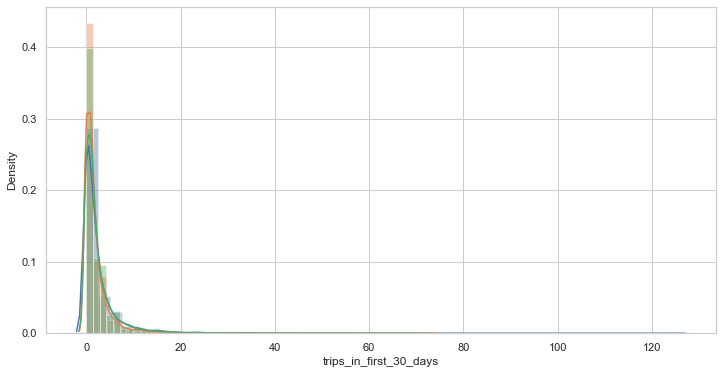

In [82]:
# Распр. явл логнормальными
sns.distplot(df[df.city == "King's Landing"].trips_in_first_30_days)
sns.distplot(df[df.city == "Astapor"].trips_in_first_30_days)
sns.distplot(df[df.city == "Winterfell"].trips_in_first_30_days)

/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/Users/anastasialutsuk/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

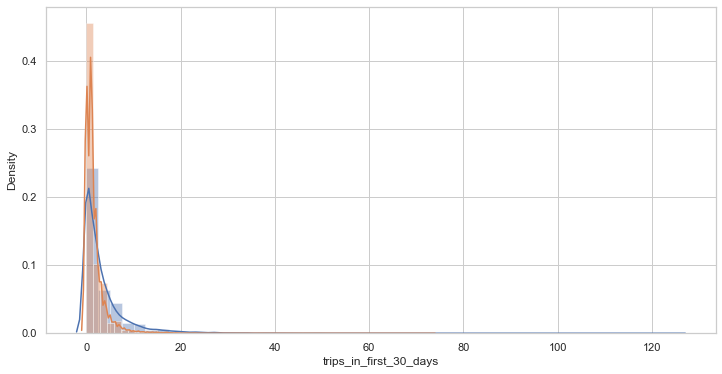

In [83]:
sns.distplot(df[df.churn == "not_churn"].trips_in_first_30_days)
sns.distplot(df[df.churn == "churn"].trips_in_first_30_days)

In [37]:
# Используем критерий Манна-Уитни для проверки для оценки различий между двумя независимыми выборками
# pvalue < 0.05, имеются статистически значимые различия 
mannwhitneyu(df.query('churn == "churn"').trips_in_first_30_days,
             df.query('churn == "not_churn"').trips_in_first_30_days)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)